In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
import tensorflow as tf
import numpy as np
import os
import pandas as pd #資料處理
import torch
import matplotlib.pyplot as plt
from PIL import Image

# 設定dataset路徑
project_path = r"D:\NTUT\Weather_AI\self-project\GAN\weather-GAN"
train_data_path = str(project_path + r"\train_data")
output_data_path = str(project_path + r"output_data")

In [74]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
class My_Dataset(Dataset) :
    def __init__(self, path, transform=None) :
        super().__init__()
        self.image_files = os.listdir(path)
        self.list_files = []
        for file in self.image_files :
            self.list_files.append(os.path.join(path, file))

    # Indicate the total size of the dataset
    def __len__(self) :
        return len(self.image_files)
    
    # 1. Read from file (using numpy.fromfile, PIL.Image.open)
    # 2. Preprocess the data (torchvision.Transform).
    # 3. Return the data (e.g. image and label)
    def __getitem__(self, index) :
        image = Image.open(self.list_files[index]).convert('RGB')
        if transform is None :
            return image
        else :
            image = transform(image)
            return image

#讀取圖片，一次四張
if __name__ == '__main__' :
    #path_image = r"D:\NTUT\Weather_AI\self-project\GAN\weather-GAN\train_data"
    path_image = train_data_path
    train_data = My_Dataset(path_image, transform=transform)
    train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
    for image in train_dataloader :
        print(image.shape)
        #4(張), 3(RGB三通道), 3600(長), 3600(寬)縮成256*256
        break

c:\Users\Wei Shen Wu\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([4, 3, 256, 256])


In [78]:
# 切割資料集
from sklearn.model_selection import train_test_split

train, test = train_test_split(image, test_size = 0.2, random_state = 42)

In [128]:
train = np.array(train)
test = np.array(test)

train.shape, test.shape

((3, 3, 256, 256), (1, 3, 256, 256))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


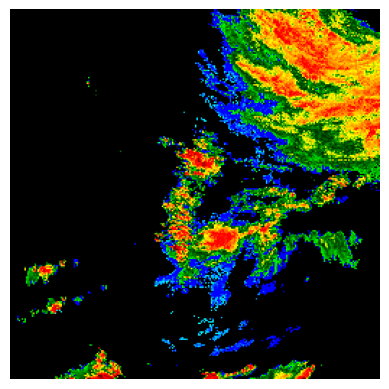

In [129]:

plt.imshow(np.transpose(test[0], (1, 2, 0)))
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


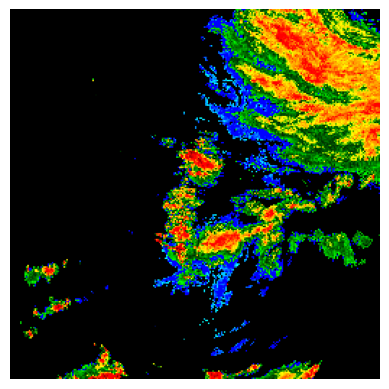

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


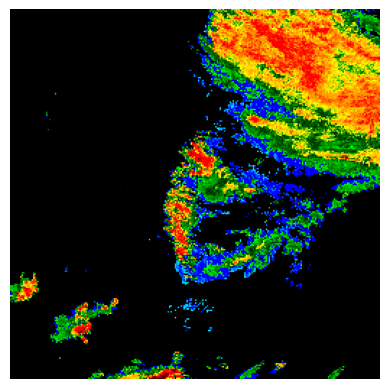

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


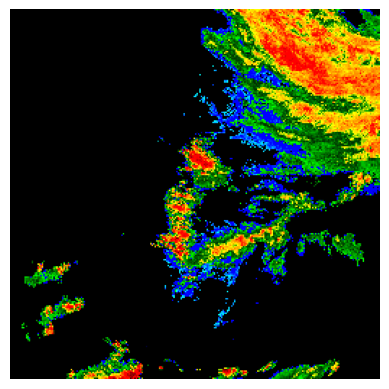

In [130]:
for i in range(len(train)) :
    plt.imshow(np.transpose(train[i], (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [77]:
print(train)

[[[[-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   ...
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]]

  [[-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   ...
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]
   [-1.         -1.         -1.         ... -1.         -1.
    -1.        ]]

  [[-1.         -1.         -1.         ... -1.         -1

In [62]:
# 把所有圖片建立成一個Dataset--weather_dataset
weather_dataset = tf.data.Dataset.list_files("train_data/*.png")
# weather_dataset = np.array(weather_dataset)
# weather_dataset.shape
data_iterator = weather_dataset.as_numpy_iterator()
data_iterator.next()

b'train_data\\08_06_44.png'

Build Nerual Network

In [12]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the NN
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Build generator

In [121]:
def build_generator() :
    model = Sequential()

    # Beginnings of a generated image
    model.add(Dense(8*8*128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8, 8, 128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 3
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 4
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 5
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Convolution block 1
    model.add(Conv2D(128, 4, padding = 'same'))
    model.add(LeakyReLU(0.2))

    # Convolution block 2
    model.add(Conv2D(128, 4, padding = 'same'))
    model.add(LeakyReLU(0.2))

    #Conv layer to get to three channel, because R,G,B
    model.add(Conv2D(3, 4, padding = 'same', activation = 'sigmoid'))

    return model

In [122]:
generator = build_generator()
generator.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 8192)              1056768   
                                                                 
 leaky_re_lu_83 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_16 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d_57 (UpSampli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_71 (Conv2D)          (None, 16, 16, 128)       409728    
                                                                 
 leaky_re_lu_84 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                     

In [123]:
img = generator.predict(np.random.randn(4, 128, 1))
img

1/1 [==============================] - 1s 912ms/step


array([[[[0.5000595 , 0.500313  , 0.49956328],
         [0.49956387, 0.5015977 , 0.49957368],
         [0.49917153, 0.50196004, 0.4994118 ],
         ...,
         [0.49949014, 0.5007281 , 0.50069773],
         [0.49969813, 0.50064296, 0.50060755],
         [0.50005686, 0.5002208 , 0.5003547 ]],

        [[0.5002195 , 0.4998357 , 0.49924687],
         [0.50014305, 0.5010451 , 0.49858645],
         [0.49973473, 0.5016293 , 0.49886054],
         ...,
         [0.49955186, 0.5003978 , 0.50012094],
         [0.49965551, 0.50054115, 0.50003195],
         [0.5000704 , 0.5000923 , 0.5001217 ]],

        [[0.5001901 , 0.49988365, 0.49877203],
         [0.5007273 , 0.50070786, 0.49808064],
         [0.50021106, 0.5018451 , 0.4983224 ],
         ...,
         [0.49996513, 0.50018996, 0.50039995],
         [0.49961862, 0.50069815, 0.5001401 ],
         [0.50004435, 0.50020707, 0.5000724 ]],

        ...,

        [[0.49971712, 0.50062144, 0.50004697],
         [0.49952143, 0.5011182 , 0.49980015]

In [124]:
print(len(img))

4


In [125]:
img.shape

(4, 256, 256, 3)

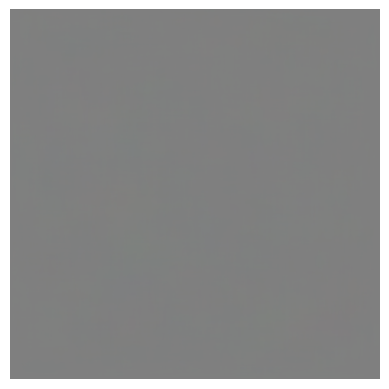

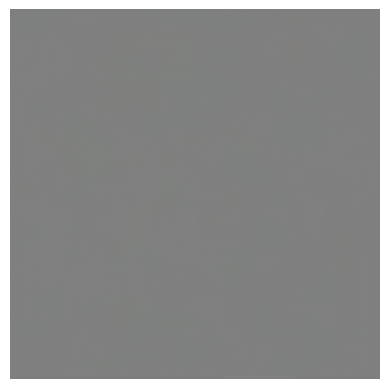

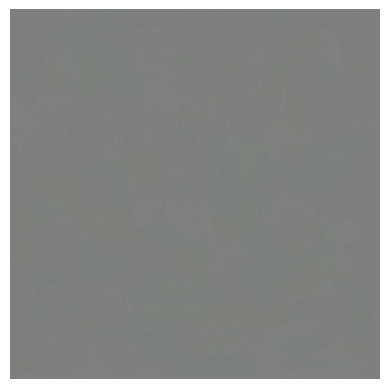

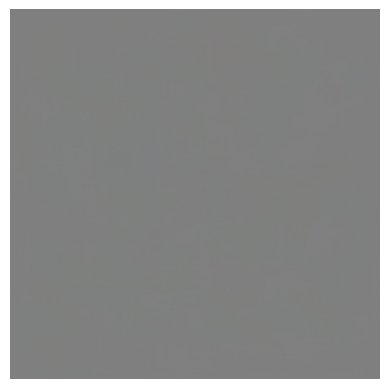

In [127]:
# fig, ax = plt.subplots(ncols = 4, figsize = (256, 256))
# for idx, img in enumerate(img) :
#     ax[idx].imshow(np.squeeze(img))
#     ax[idx].title.set_text(idx)
img = np.array(img)

for i in range(len(img)) :
    plt.imshow(img[i])
    plt.axis('off')
    plt.show()